## Họ và tên : Trần Anh Thái
## MSSV : 22H1320007

## nạp dữ liệu với 3 nhóm tin : 'sci.space', 'soc.religion.christian', 'talk.politics.guns'.

In [1]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = [
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

2894 documents - 3 categories


In [2]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## Trích xuất đặc trưng bằng TfidVectorizer

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.21 ± 0.06 s 
Homogeneity: 0.389 ± 0.033
Completeness: 0.461 ± 0.025
V-measure: 0.422 ± 0.030
Adjusted Rand-Index: 0.286 ± 0.052
Silhouette Coefficient: 0.010 ± 0.001


## Giảm kích thước bằng LSA



In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.16 ± 0.03 s 
Homogeneity: 0.503 ± 0.094
Completeness: 0.555 ± 0.042
V-measure: 0.526 ± 0.074
Adjusted Rand-Index: 0.468 ± 0.122
Silhouette Coefficient: 0.033 ± 0.002


## Sử dụng HashingVectorizer

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)

fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.08 ± 0.01 s 
Homogeneity: 0.475 ± 0.104
Completeness: 0.543 ± 0.049
V-measure: 0.504 ± 0.082
Adjusted Rand-Index: 0.434 ± 0.145
Silhouette Coefficient: 0.031 ± 0.002


## Đánh giá tổng thể

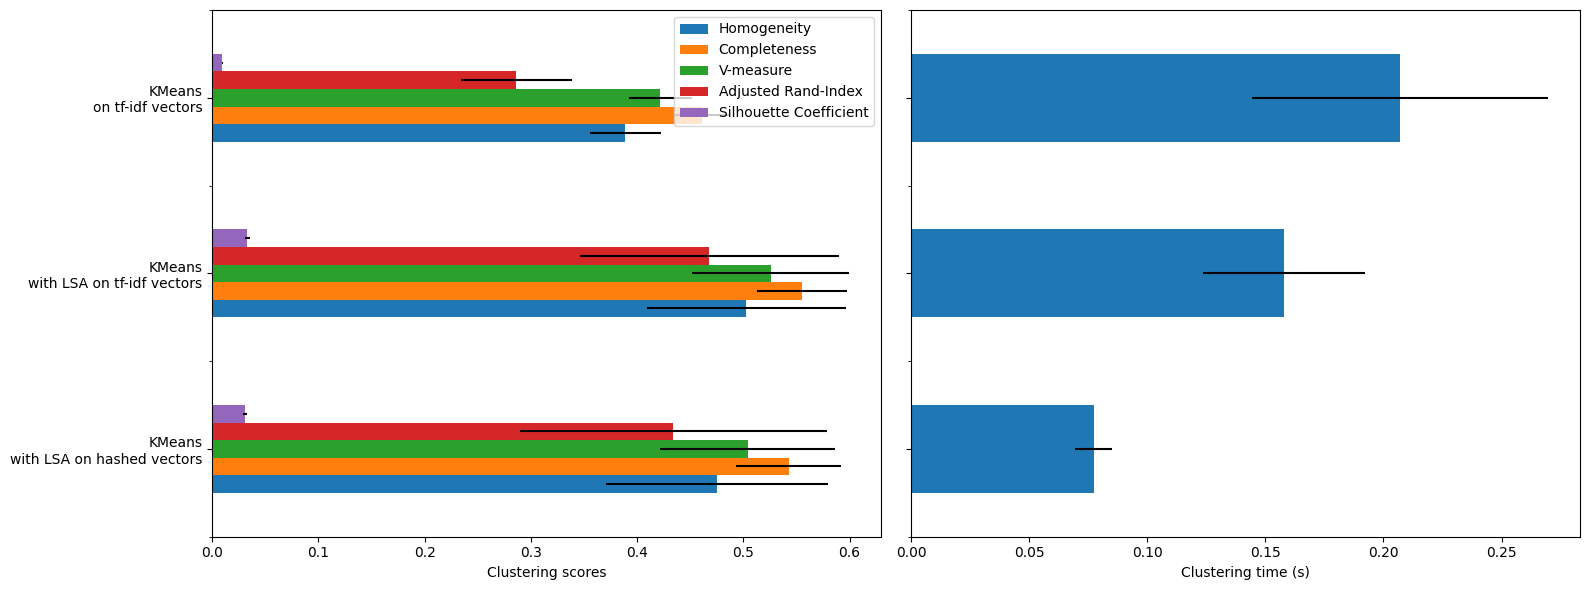

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()